# Fig 4: Gaussian process

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`
including the MSD analysis

## Setup

In [1]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

In [7]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);
unique(data_gp.length)
names(data_gp)

14-element Vector{String}:
 "matern32_cell"
 "matern32_cell_var"
 "matern32_cell_x"
 "matern32_cell_x_var"
 "matern32_flucs"
 "matern32_flucs_var"
 "matern32_flucs_x"
 "matern32_flucs_x_var"
 "time"
 "position"
 "linear"
 "lineage"
 "age"
 "length"

## High-level visualization of output

### consistency with raw data and example decomposition

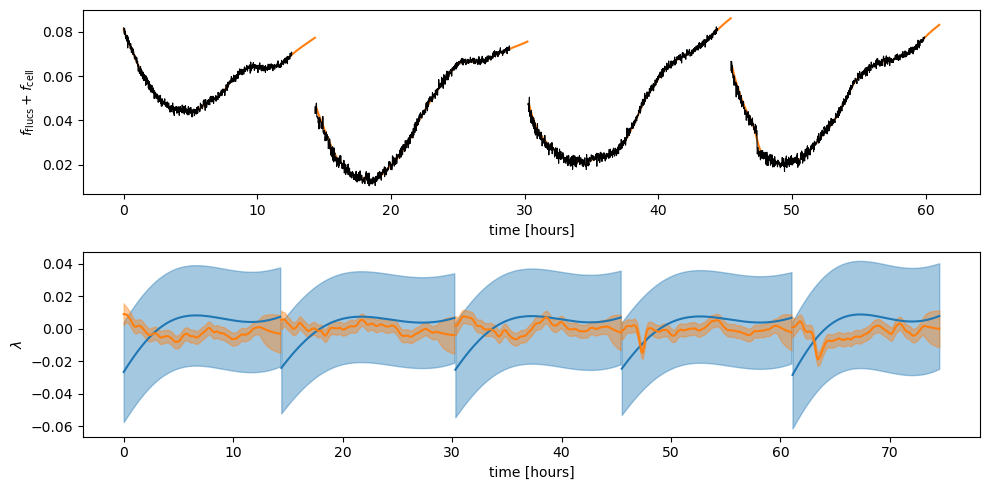

In [8]:
fig,axs = subplots(figsize=(10,5),nrows=2)
k = 5

# -----------------------------------------------------------------------------
# consistency with raw data
ax = axs[0]
dr = data_raw[data_raw.lineage .== lineages[k],:]
dr = dr[dr.cellcycle .== "i",:]
dr.time = dr.time .- dr.time[1]
y = dr.lnM_sum 
t = dr.time
dr[:,:z] = y .- cov(y,t)/var(t) .*t
dr[:,:z] = dr.z .- mean(dr.z)

pred = data_gp[data_gp.lineage .== lineages[k],:]
pred.time = pred.time .- pred.time[1]
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)[1:4]
    d = pred[pred.position .==p,:]
    #ax.plot(d.time,d.matern32_cell_x,"C0-")
    ax.plot(d.time,d.matern32_flucs .+ d.matern32_cell,"C1-",label="GP")
    d = dr[dr.position .==p,:]
    ax.plot(d.time,d.z,"k-",lw=0.8,label="data")

end
ax.set_ylabel(L"$f_{\rm flucs} + f_{\rm cell}$")
ax.set_xlabel("time [hours]")

# -----------------------------------------------------------------------------
# relative size of terms
ax = axs[1]
GrowthTraceTools.get_gen_times!(pred);
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)[1:5]
    d = pred[pred.position .== p,:]

    m,s = d.matern32_cell_x ./ d.gen_time[1],2.0*sqrt.( abs.( d.matern32_cell_x_var))./ d.gen_time[1]
    ax.plot(d.time, m  ,"C0-")
    ax.fill_between(d.time,m .- s,m .+ s,alpha=0.4,color="C0")

    m,s = d.matern32_flucs_x, 2.0* sqrt.(d.matern32_flucs_x_var)
    ax.plot(d.time,m,"C1-")
    ax.fill_between(d.time,m .- s,m .+ s,alpha=0.4,color="C1")
end
ax.set_ylabel(L"$\lambda$")
ax.set_xlabel("time [hours]")
tight_layout()
fig


### Relative contributions to cell-cycle averaged dynamics ($\bar{\lambda}$)

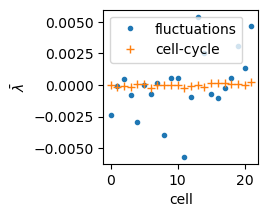

In [9]:
fig,ax = subplots(figsize=(2,2))
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
positions = unique(pred.position)
d = pred
λbar_flucs = [mean(d[d.position .== p,:].matern32_flucs_x) for p in positions]
λbar_cell = [mean(d[d.position .== p,:].matern32_cell_x  ./ d[d.position .== p,:gen_time][1]) for p in positions]
ax.plot(λbar_flucs .- mean(λbar_flucs) ,"C0.",label="fluctuations")
ax.plot(λbar_cell .- mean(λbar_cell) ,"C1+",label="cell-cycle")
ax.set_ylabel(L"$\bar{\lambda}$")
ax.set_xlabel("cell")
ax.legend(frameon=true)
fig

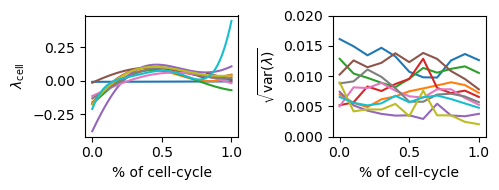

In [10]:


fig, axs= subplots(figsize=(5,2),ncols=2)

# ------------------------------------------------------
# trend
ax = axs[0]
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    pred = pred[pred.position .==1,:]
    an = pred.time .- pred.time[1]
    an = an ./ an[end]
    ax.plot(an,pred.matern32_cell_x)
end
ax.set_xlabel("% of cell-cycle")
ax.set_ylabel(L"$\lambda_{\rm cell}$")

# ------------------------------------------------------
# variance vs. cell-cycle
ax = axs[1]
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    if length(unique(pred.position))>6
        pred = combine(groupby(pred,:position),:time => (x -> x .- x[1]) => :age,:time => (x -> (x .- x[1]) ./ (x[end] - x[1])) => :age_normed,names(pred))
        pred[:,:age_normed] = round.(pred.age_normed,digits=1)
        vdf = combine(groupby(pred,:age_normed),:matern32_flucs_x => std => :v)
        sort!(vdf,:age_normed)
        ax.plot(vdf.age_normed,vdf.v,"-")
    end
end
ax.set_ylim([0,0.02])
ax.set_xlabel("% of cell-cycle")
ax.set_ylabel(L"$\sqrt{{\rm var}(\lambda)}$")
tight_layout()
fig
